# Text Mining - Sentiment Analysis

In [1]:
%matplotlib inline

from utils import plot_confusion_matrix, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import stem, FreqDist
import pandas as pd
from pandas import DataFrame
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, SGDClassifier, RidgeClassifier
from sklearn import metrics

pd.set_option('display.max_rows', 10)

In [2]:
documents = pd.read_csv('data/carros.csv', delimiter=';')

# visualize
documents.head()

,Classe,Texto
0,Contras,"cheiro ruim depois que desliga o ar, seta impr..."
1,Contras,"peças um pouco mais caras, revenda, o povo bra..."
2,Contras,"Ruídos internos excessivos, a suspensão faz um..."
3,Contras,"Muito barulhento, pelo que me falaram o consum..."
4,Contras,nada a declarar.


## Dividindo os documentos entre treino e teste

In [3]:
train_set, test_set = train_test_split(documents, test_size=0.2, random_state=37)
classes = set(train_set['Classe'])

In [4]:
train_set['Classe'].value_counts()

Pros       1243
Contras    1173
Name: Classe, dtype: int64

In [5]:
test_set['Classe'].value_counts()

Pros       303
Contras    302
Name: Classe, dtype: int64

## Tokenize

In [6]:
def tokenize(text):
    return RegexpTokenizer(r'\w+').tokenize(text)

tokenize(documents['Texto'][2])[:5]

['Ruídos', 'internos', 'excessivos', 'a', 'suspensão']

## Remove Stop Words

In [7]:
stop_words = set(stopwords.words("portuguese"))

# remoção de algumas palavras
stop_words.difference_update(set(['não', 'nem']))

def remove_stop_words(words):
    words = [w for w in words if w not in stop_words]
    return words

list(stop_words)[:10]

['elas',
 'me',
 'eles',
 'pelas',
 'tinham',
 'entre',
 'pelo',
 'foi',
 'nossos',
 'das']

In [8]:
text = tokenize(documents['Texto'][0])
print('Original: ', len(text))

text_cleaned = remove_stop_words(text)
print('Sem as stop words:', len(text_cleaned))

Original:  55
Sem as stop words: 37


In [9]:
text_cleaned[:6]

['cheiro', 'ruim', 'desliga', 'ar', 'seta', 'imprecisa']

## Stemmer

In [10]:
def stem_words(words):
    stemmer = nltk.stem.RSLPStemmer()
    words = [stemmer.stem(w) for w in words]
    return words

In [11]:
# Exemplo
stem_words(remove_stop_words(tokenize(documents['Texto'][0])))[:6]

['cheir', 'ruim', 'deslig', 'ar', 'set', 'imprecis']

## Análise - Palavras mais frequentes

In [32]:
all_words = train_set['Texto'].apply(lambda x: stem_words(remove_stop_words(tokenize(x))))
all_words = [word for doc in all_words for word in doc]

print("All words:", len(all_words))

# Words Most Common
DataFrame(FreqDist(all_words).most_common(10))

All words: 47710


,0,1
0,é,1379
1,carr,1371
2,não,766
3,motor,642
4,o,499
5,port,485
6,intern,473
7,bom,456
8,consum,448
9,1,437


## Vectorize

In [13]:
def clean_and_tokenize(text):
    tokens = tokenize(text)
    tokens = remove_stop_words(tokens)
    tokens = stem_words(tokens)
    return tokens

In [31]:
# tf–idf
vectorizer = TfidfVectorizer(tokenizer=clean_and_tokenize, max_features=10000)

train_X = vectorizer.fit_transform(train_set['Texto'].values)
train_Y = train_set['Classe'].values
features = vectorizer.get_feature_names()

test_X = vectorizer.transform(test_set['Texto'].values)
test_Y = test_set['Classe'].values

# Visualize
DataFrame(train_X.toarray(), columns=features).head()

,0,00,000,000km,000rpm,00complet,01,02,03,04,...,óim,óle,óptic,ótim,ótmi,ônibu,últ,únic,útel,útil
0,0.136731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Treinar e Validar

In [15]:
def train_and_get_score(classifier, x, y, test_X, test_Y, n_splits=3):
    clf.fit(x, y)
    scores = cross_val_score(classifier, x, y, cv=n_splits)
    print("CROSS VALIDATION SCORE: Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print("SAME DATASET SCORE: Accuracy: %0.2f" % clf.score(train_X, train_Y))
    print("TEST SCORE: Accuracy: %0.2f" % clf.score(test_X, test_Y))

### Naive Bayes

In [39]:
clf = MultinomialNB()
train_and_get_score(clf, train_X, train_Y, test_X, test_Y, 10)

CROSS VALIDATION SCORE: Accuracy: 0.91 (+/- 0.05)
SAME DATASET SCORE: Accuracy: 0.95
TEST SCORE: Accuracy: 0.93


Confusion matrix, without normalization
[[1090   83]
 [  44 1199]]


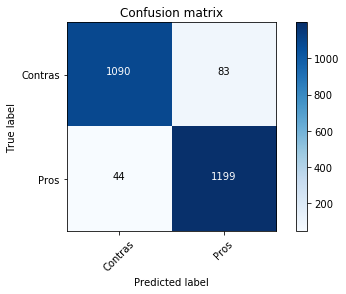

In [40]:
plot_confusion_matrix(confusion_matrix(train_Y, clf.predict(train_X)), classes=classes)

Ao testar a frase "Parece uma nave" o resultado deu contra, sendo que no RapidMiner deu positivo.

In [41]:
clf.predict(vectorizer.transform(['Parece uma nave.']))[0]

'Contras'

In [42]:
clf = BernoulliNB()
train_and_get_score(clf, train_X, train_Y, test_X, test_Y, 10)

'Parece uma nave.' + ' = ' + clf.predict(vectorizer.transform(['Parece uma nave.']))[0]

CROSS VALIDATION SCORE: Accuracy: 0.87 (+/- 0.04)
SAME DATASET SCORE: Accuracy: 0.91
TEST SCORE: Accuracy: 0.88


'Parece uma nave. = Pros'

### Random Forest

In [43]:
clf = RandomForestClassifier(criterion='entropy')
train_and_get_score(clf, train_X, train_Y, test_X, test_Y)

CROSS VALIDATION SCORE: Accuracy: 0.87 (+/- 0.00)
SAME DATASET SCORE: Accuracy: 0.99
TEST SCORE: Accuracy: 0.88


In [44]:
'Parece uma nave.' + ' = ' + clf.predict(vectorizer.transform(['Parece uma nave.']))[0]

'Parece uma nave. = Contras'

### Ridge regression

In [45]:
clf = RidgeClassifier()
train_and_get_score(clf, train_X, train_Y, test_X, test_Y)

CROSS VALIDATION SCORE: Accuracy: 0.91 (+/- 0.00)
SAME DATASET SCORE: Accuracy: 0.98
TEST SCORE: Accuracy: 0.94


In [46]:
'Parece uma nave.' + ' = ' + clf.predict(vectorizer.transform(['Parece uma nave.']))[0]

'Parece uma nave. = Contras'

## Otimizações

### n-Grams

In [26]:
vectorizer = TfidfVectorizer(tokenizer=clean_and_tokenize, ngram_range=[1,3], max_features=10000)

ng_train_X = vectorizer.fit_transform(train_set['Texto'].values)
ng_train_Y = train_set['Classe'].values

ng_test_X = vectorizer.transform(test_set['Texto'].values)
ng_test_Y = test_set['Classe'].values

DataFrame(ng_train_X.toarray(), columns=vectorizer.get_feature_names()).head()

,0,0 100,0 16v,0 8v,0 acab,0 agor,0 and,0 and bem,0 bom,0 bom consum,...,ótim torqu,ótim visibil,últ,únic,únic cois,únic cois não,únic peç,únic pont,únic pont posi,útil
0,0.084605,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Naive Bayes

In [27]:
clf = MultinomialNB()
train_and_get_score(clf, ng_train_X, ng_train_Y, ng_test_X, ng_test_Y, 10)

CROSS VALIDATION SCORE: Accuracy: 0.92 (+/- 0.04)
SAME DATASET SCORE: Accuracy: 0.97
TEST SCORE: Accuracy: 0.94


### Random Forest

In [28]:
clf = RandomForestClassifier(criterion='entropy')
train_and_get_score(clf, ng_train_X, ng_train_Y, ng_test_X, ng_test_Y)

CROSS VALIDATION SCORE: Accuracy: 0.87 (+/- 0.00)
SAME DATASET SCORE: Accuracy: 0.99
TEST SCORE: Accuracy: 0.88


### Ridge regression

In [29]:
clf = RidgeClassifier()
train_and_get_score(clf, ng_train_X, ng_train_Y, ng_test_X, ng_test_Y)

CROSS VALIDATION SCORE: Accuracy: 0.92 (+/- 0.01)
SAME DATASET SCORE: Accuracy: 0.99
TEST SCORE: Accuracy: 0.95


** RESULTADO: leve melhoria no naive bayes e a acuracidade do Random Forest caiu **

### IDEIAS

- Corrigir palavras
- Remover números e adicionar hasNumber como uma feature